In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K
#from tensorflow.python.keras import backend as K
import glob
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, BatchNormalization, Dropout, Reshape
from keras.models import Model
from matplotlib import pyplot

Using TensorFlow backend.


In [3]:
all_files = glob.glob("data/*.csv")
#all_files = glob.glob("data/autopilot_2019_03_18__13_20_22.csv")

li = []
for filename in all_files:
    print("Loading", filename)
    df = pd.read_csv(filename, header=None)
    df.drop(df.tail(1).index,inplace=True)
    li.append(df)

dataset = pd.concat(li, axis=0).sample(frac=1)

#DEV TO REDUCE DATASET
#dataset = dataset.iloc[:1000,:]

Y_data = dataset.iloc[:,-2:]
X_data = dataset.iloc[:,:-2]

Loading data/autopilot_2019_03_18__13_17_35.csv
Loading data/autopilot_2019_03_18__13_20_22.csv
Loading data/autopilot_2019_03_17__02_57_50.csv
Loading data/autopilot_2019_03_17__03_55_47.csv
Loading data/autopilot_2019_03_18__12_42_35.csv
Loading data/autopilot_2019_03_17__03_57_58.csv
Loading data/autopilot_2019_03_18__13_19_00.csv
Loading data/autopilot_2019_03_17__03_51_44.csv
Loading data/autopilot_2019_03_18__13_16_35.csv
Loading data/autopilot_2019_03_18__12_44_29.csv
Loading data/autopilot_2019_03_18__13_09_23.csv
Loading data/autopilot_2019_03_17__03_54_00.csv
Loading data/autopilot_2019_03_18__12_43_28.csv
Loading data/autopilot_2019_03_17__03_53_15.csv
Loading data/autopilot_2019_03_18__12_41_36.csv
Loading data/autopilot_2019_03_17__02_59_54.csv
Loading data/autopilot_2019_03_18__13_08_17.csv
Loading data/autopilot_2019_03_18__12_41_05.csv
Loading data/autopilot_2019_03_17__03_54_47.csv
Loading data/autopilot_2019_03_17__03_59_32.csv
Loading data/autopilot_2019_03_18__13_15

In [4]:
split_offset = int(X_data.shape[0] * .05)
Y_test  = Y_data.iloc[:split_offset,:]
Y_train = Y_data.iloc[split_offset:,:]
X_test  = X_data.iloc[:split_offset,:]
X_train = X_data.iloc[split_offset:,:]
assert X_train.shape[1] == X_test.shape[1]
assert Y_train.shape[1] == Y_test.shape[1]
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]
print(X_train.shape[1], "feature values")
print(Y_train.shape[1], "output values")
print(X_train.shape[0], "training lines")
print(Y_test.shape[0], "testing lines")

2271 feature values
2 output values
40186 training lines
2115 testing lines


In [5]:
first_selfcar_inputs = 3
features_by_car = 6
cells_by_row = 18
car_features = cells_by_row * cells_by_row * features_by_car
blocks_offset = first_selfcar_inputs + car_features

raw_input = Input(shape=(X_train.shape[1],), name='raw_input')

selfcar = Lambda(
    lambda x: K.slice(x, [0,0], [-1,first_selfcar_inputs]),
    output_shape=(first_selfcar_inputs,),
    name='selfcar_input'
)(raw_input)

blocks = Lambda(
    lambda x: K.slice(x, [0,blocks_offset], [-1,-1]),
    output_shape=(cells_by_row * cells_by_row,),
    name='blocks_input_slice'
)(raw_input)

blocks = Reshape(
    (cells_by_row, cells_by_row, 1,),
    input_shape=(cells_by_row, cells_by_row, 1,),
    name='blocks_input_reshape'
)(blocks)

cars = Lambda(
    lambda x: K.slice(x, [0,first_selfcar_inputs], [-1,car_features]),
    output_shape=(car_features,),
    name='cars_input_slice'
)(raw_input)

cars = Reshape(
    (cells_by_row, cells_by_row, features_by_car,),
    input_shape=(cells_by_row * cells_by_row * features_by_car,),
    name='cars_input_reshape'
)(cars)

blocks = Conv2D(24, (4, 4), strides=2, name='conv_blocks_1')(blocks)
blocks = Dropout(.3)(blocks)
blocks = Conv2D(48, (6, 6), name='conv_blocks_2')(blocks)
blocks = Flatten(name='flatten_blocks')(blocks)

cars = Conv2D(12, (3, 3), name='conv_cars_1')(cars)
cars = Dropout(.3)(cars)
cars = Conv2D(24, (5, 5), strides=2, name='conv_cars_2')(cars)
cars = Flatten(name='flatten_cars')(cars)

all_features = Concatenate(name='all_features')([blocks, cars, selfcar])
all_features = Dropout(.3)(all_features)
all_features = Dense(512, activation='relu')(all_features)
all_features = Dropout(.3)(all_features)
driving = Dense(2, activation='tanh')(all_features)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model = Model(inputs=raw_input, outputs=driving, name='first_try')
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
raw_input (InputLayer)          (None, 2271)         0                                            
__________________________________________________________________________________________________
blocks_input_slice (Lambda)     (None, 324)          0           raw_input[0][0]                  
__________________________________________________________________________________________________
cars_input_slice (Lambda)       (None, 1944)         0           raw_input[0][0]                  
__________________________________________________________________________________________________
blocks_input_reshape (Reshape)  (None, 18, 18, 1)    0           blocks_input_slice[0][0]         
__________________________________________________________________________________________________
cars_input

In [9]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.
Train on 40186 samples, validate on 2115 samples
Epoch 1/10
40186/40186 [==============================] - 22s 548us/step - loss: 0.1823 - acc: 0.7263 - val_loss: 0.1631 - val_acc: 0.7357
Epoch 2/10
40186/40186 [==============================] - 23s 562us/step - loss: 0.1627 - acc: 0.7365 - val_loss: 0.1578 - val_acc: 0.7381
Epoch 3/10
40186/40186 [==============================] - 22s 555us/step - loss: 0.1585 - acc: 0.7413 - val_loss: 0.1561 - val_acc: 0.7385
Epoch 4/10
40186/40186 [==============================] - 22s 555us/step - loss: 0.1564 - acc: 0.7424 - val_loss: 0.1549 - val_acc: 0.7428
Epoch 5/10
40186/40186 [==============================] - 22s 551us/step - loss: 0.1547 - acc: 0.7433 - val_loss: 0.1544 - val_acc: 0.7475
Epoch 6/10
40186/40186 [==============================] - 22s 560us/step - loss: 0.1531 - acc: 0.7460 - val_loss: 0.1545 - val_acc: 0.7390
Epoch 7/10
40186/40186 [==============================] - 23s 563us/s

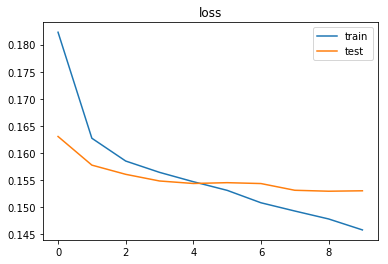

In [10]:
pyplot.title('loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

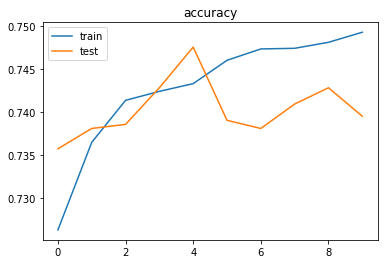

In [11]:
pyplot.title('accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

In [12]:
for index in range(0, 5):
    print(Y_test.values[index])
    print(model.predict(X_test.values[index:index+1,:])[0])
    print("---------")

[ 0.45696872 -0.75256492]
[0.03749104 0.22736354]
---------
[-0.08436176  0.61051122]
[-0.05141671  0.46655667]
---------
[0.20783049 0.69163082]
[0.00065099 0.4239106 ]
---------
[-0.63945812  0.52776239]
[-0.11975555  0.47938183]
---------
[ 0.6167899  -0.41631181]
[-0.01646869  0.37334648]
---------


In [18]:
import os, time
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants, signature_constants, signature_def_utils_impl

prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def(
    {"raw": model.input},
    {"drive": model.output}
)
export_path = os.path.join(
    tf.compat.as_bytes('models/export/{}'.format(model.name)),
    tf.compat.as_bytes('2')
)
builder = saved_model_builder.SavedModelBuilder(export_path)
sess = K.get_session()
builder.add_meta_graph_and_variables(
    sess, [tag_constants.SERVING],
    signature_def_map={'raw': prediction_signature}
)
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/export/first_try/2/saved_model.pb


b'models/export/first_try/2/saved_model.pb'